## Worflow
- Set network parameters
- Optimize for twiddle bits
- Collect training and validation data
- Train for wiggly function
- Validate training

Fixed parameters:
- number of neurons

Swept parameters:
- function wiggliness
- fmax

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from nengo_brainstorm.solvers import CVXSolver
from nengo_extras.plot_spikes import plot_spikes

import pystorm
from pystorm.hal import HAL
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.calibrator import Calibrator, PoolSpec
from pystorm.hal.data_utils import lpf, bin_to_spk_times, bins_to_rates

import utils

In [2]:
# fixed parameters
# network parameters
X = 16
Y = 16
NNEURON = X*Y
DIM = 1
# experimental parameters
TRAINING_DOWNSTREAM_NS = 10000 # minimum time resolution, downstream time resolution
TRAINING_UPSTREAM_NS   = 1000000 # default upstream time resolution
FMAX_IN = 1000
INPUT_POINTS = 321 # number of input points to take for collecting tuning data
TUNING_POINT_TIME_NS = int(2*1E9) # time to record data per tuning curve input point
VALIDATION_SKIP = 5 # reserve every VALIDATION_SKIP points from tuning data for validation
TESTING_DOWNSTREAM_NS = 1000 # upstraem time resolution for testing
TESTING_UPSTREAM_NS = 1000 # upstraem time resolution for testing
CLIP_TIME = 0.2 # how much of the initial data to discard during testing
TAU_READOUT = 0.01 # synaptic readout time constant
REG_L2 = 1000.
REG_L1 = 1000.

PS_ORIG = PoolSpec(
    label = "pool",
    YX = (Y, X),
    loc_yx = (0, 0),
    D = DIM,
)

def FCN(x, f):
    """Base function used in testing"""
    return 0.5 + 0.5*np.sin(np.pi*f*x)
    
# swept parameters
FMAX_OUTS = [1500, 1000, 500]
FCN_F = [0.5, 1., 1.5, 2.0]

In [3]:
class ExpData:
    def __init__(self, fmax_in, fmax_outs, fcn_fs):
        self.fmax_in = fmax_in
        self.fmax_outs = fmax_outs
        self.fcn_fs = fcn_fs

    def collect_tuning_data(self, net, hal, run_control,
                       input_points, time_per_point_ns):
        """Collect tuning data to be used when fitting decoders"""
        hal.set_time_resolution(TRAINING_DOWNSTREAM_NS, TRAINING_UPSTREAM_NS)

        time_points_ns = np.arange(input_points+1)*time_per_point_ns
        input_rates = np.zeros((input_points+1, 1))
        input_rates[:input_points, 0] = self.fmax_in * np.linspace(-1, 1, input_points)
        input_rates[-1, 0] = input_rates[-2, 0]
        input_data = {net.input:(time_points_ns, input_rates)}

        fname_cache = ("tuning" + "_" + str(PS_ORIG.YX) + "_" +
               str(PS_ORIG.loc_yx) + "_" + str(input_points) + "_" + str(time_per_point_ns) + ".pck")
        def sweep_fun():
            _, spike_data = run_control.run_input_sweep(
                input_data, get_raw_spikes=True, get_outputs=False)
            spikes, bin_times_ns = spike_data
            spikes = spikes[net.pool]    
            spike_rates = bins_to_rates(spikes, bin_times_ns,
                                        time_points_ns, init_discard_frac=0.25)
            return spike_rates
        spike_rates = utils.cache_fun(fname_cache, sweep_fun)

        self.tuning_input_rates = input_rates[:-1]
        self.tuning_spike_rates = spike_rates
        
    def split_tuning_data(self, valid_skip):
        """split into training and validation sets"""
        input_points = len(self.tuning_input_rates)
        start_idx = valid_skip//2
        t_idx = np.ones(input_points, dtype=bool)
        t_idx[start_idx::valid_skip] = False
        v_idx = ~t_idx
        self.training_input_rates = self.tuning_input_rates[t_idx]
        self.training_spike_rates = self.tuning_spike_rates[t_idx]
        self.validation_input_rates = self.tuning_input_rates[v_idx]
        self.validation_spike_rates = self.tuning_spike_rates[v_idx]

    def plot_tuning(self, array_width, array_height):
        inputs = self.tuning_input_rates
        spike_rates = self.tuning_spike_rates
        t_inputs = self.training_input_rates
        t_spike_rates = self.training_spike_rates
        v_inputs = self.validation_input_rates
        v_spike_rates = self.validation_spike_rates

        fig, (ax_all, ax_t, ax_v) = plt.subplots(ncols=3, figsize=(14, 4), sharex=True)

        half_width = array_width//2
        for idx in range(array_height):
            start_l = idx*array_width
            start_r = start_l + half_width
            ax_all.plot(inputs, spike_rates[:, start_l:start_l+half_width], 'r')
            ax_all.plot(inputs, spike_rates[:, start_r:start_r+half_width], 'b')

            ax_t.plot(t_inputs, t_spike_rates[:, start_l:start_l+half_width], 'r-o')
            ax_t.plot(t_inputs, t_spike_rates[:, start_r:start_r+half_width], 'b-o')    
            ax_v.plot(v_inputs, v_spike_rates[:, start_l:start_l+half_width], 'r-o')
            ax_v.plot(v_inputs, v_spike_rates[:, start_r:start_r+half_width], 'b-o')    
        ax_all.set_title("All tuning data")
        ax_t.set_title("Training tuning data")
        ax_v.set_title("Validation tuning data")
        fig.savefig("test_accumulator_tuning.png")

EXP_DATA = ExpData(FMAX_IN, FMAX_OUTS, FCN_F)

In [4]:
hal = pystorm.hal.HAL()
net_builder = NetBuilder(hal)
calibrator = Calibrator(hal)

In [5]:
def build_net(ps_orig, net_builder, calibrator):
    d_matrix = np.zeros((2, Y*X))    
    p_fname = (ps_orig.label + "_" + str(ps_orig.YX) + "_" +
               str(ps_orig.loc_yx) + "_" + str(ps_orig.D) + ".pck")
    ps = utils.optimize_yield_w_cache(ps_orig, p_fname, calibrator)
    # add yield plot
    net = net_builder.create_single_pool_net_from_spec(ps, d_matrix)
    return net

net = build_net(PS_ORIG, net_builder, calibrator)
run_control = RunControl(hal, net)
hal.map(net)

# Collect Tuning Data

- Check that tuning curves look reasonable

In [6]:
EXP_DATA.collect_tuning_data(
    net, hal, run_control, INPUT_POINTS, TUNING_POINT_TIME_NS)

In [7]:
EXP_DATA.split_tuning_data(VALIDATION_SKIP)

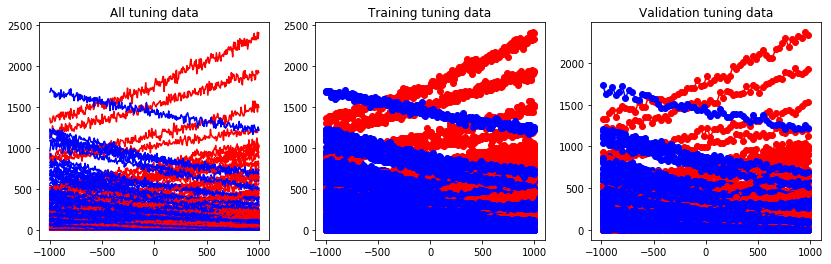

In [8]:
EXP_DATA.plot_tuning(X, Y)

# Train and Validate Decoders

In [9]:
FSCALE = 1000.
REG_L2 = .01
REG_L1 = .01

def fit_decoders(rates, target_function):
    solver = CVXSolver(reg=REG_L2, reg_l1=REG_L1)
    decoders, info = solver(rates/FSCALE, target_function/FSCALE)
    decoders = decoders.clip(-1, 1)
    return decoders, info

def run_fits(exp_data):
    exp_data.decoders = []
    exp_data.training_targets = []
    t_input = exp_data.training_input_rates/exp_data.fmax_in
    for fmax_out in exp_data.fmax_outs:
        exp_data.training_targets += [[]]
        exp_data.decoders += [[]]
        for fcn_f in exp_data.fcn_fs:
            t_targets = fmax_out * FCN(
                t_input, fcn_f) 
            print("Solving for fmax_out {:.0f} fcn_f {:.1f}".format(fmax_out, fcn_f))
            decoders, info = fit_decoders(
                exp_data.training_spike_rates, t_targets)
            exp_data.training_targets[-1] += [t_targets]
            exp_data.decoders[-1] += [decoders]
    exp_data.training_input = t_input

run_fits(EXP_DATA)

Solving for fmax_out 1500 fcn_f 0.5
Solving for fmax_out 1500 fcn_f 1.0
Solving for fmax_out 1500 fcn_f 1.5
Solving for fmax_out 1500 fcn_f 2.0
Solving for fmax_out 1000 fcn_f 0.5
Solving for fmax_out 1000 fcn_f 1.0
Solving for fmax_out 1000 fcn_f 1.5
Solving for fmax_out 1000 fcn_f 2.0
Solving for fmax_out 500 fcn_f 0.5
Solving for fmax_out 500 fcn_f 1.0
Solving for fmax_out 500 fcn_f 1.5
Solving for fmax_out 500 fcn_f 2.0


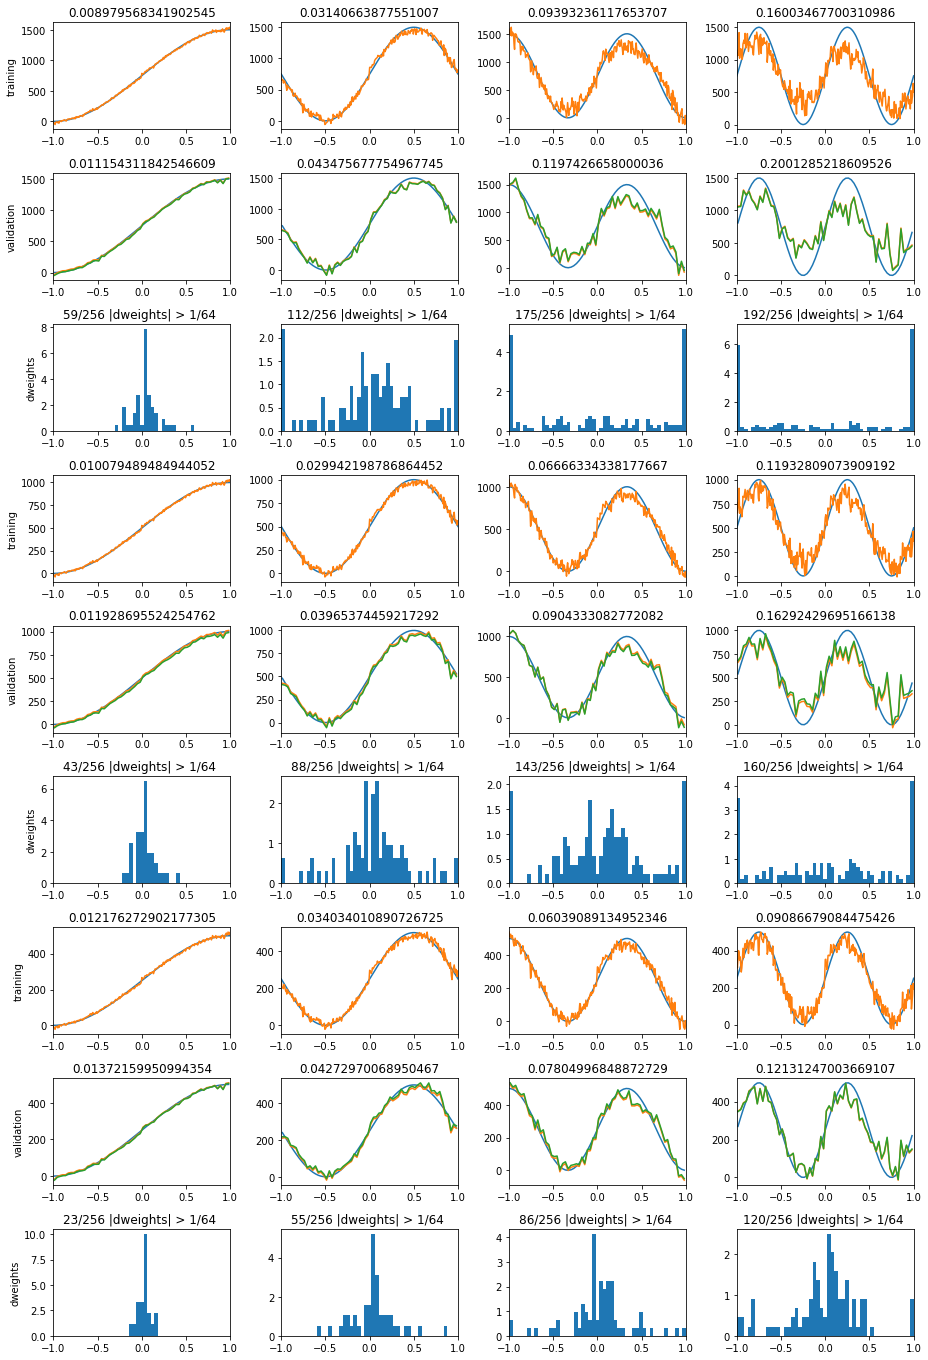

In [10]:
def check_plot_fits(exp_data):
    t_spike_rates = exp_data.training_spike_rates
    v_spike_rates = exp_data.validation_spike_rates
    
    t_input = exp_data.training_input_rates/exp_data.fmax_in
    v_input = exp_data.validation_input_rates/exp_data.fmax_in
    
    stim0_idx = np.argmin(np.abs(exp_data.tuning_input_rates)) # omit neurons that don't fire at 0
    spike_rates0 = exp_data.tuning_spike_rates[stim0_idx]
    nz_nrn0_idx = spike_rates0 > 0.
    
    hist_bins = np.linspace(-1, 1, 50)
    
    q_levels = 64
    q_res = 1/q_levels
    q_bins = np.hstack((-np.arange(q_levels+1)[::-1], np.arange(q_levels+1)[1:]))*q_res
    nrows = 3*len(exp_data.fmax_outs)
    ncols = len(exp_data.fcn_fs)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3+1,nrows*2+1))
    if ncols==1:
        axs = np.array([axs]).T.tolist()
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            decoders = exp_data.decoders[idx0][idx1]
            q_idx = np.digitize(decoders-q_res/2, q_bins)
            q_decoders = q_bins[q_idx].reshape(decoders.shape)
            nz_decoders = decoders[np.logical_and(np.abs(decoders) >= 1/64, nz_nrn0_idx.reshape(-1, 1))]
            t_target = exp_data.training_targets[idx0][idx1]
            v_target = fmax_out * FCN(v_input, fcn_f)
            t_fit = np.dot(t_spike_rates, decoders)
            v_fit = np.dot(v_spike_rates, decoders)
            vq_fit = np.dot(v_spike_rates, q_decoders)
            t_nrmse = np.sqrt(np.mean((t_fit - t_target)**2))/fmax_out
            v_nrmse = np.sqrt(np.mean((v_fit - v_target)**2))/fmax_out
            vq_nrmse = np.sqrt(np.mean((vq_fit - v_target)**2))/fmax_out
            axs[idx0*3+0][idx1].plot(t_input, t_target)
            axs[idx0*3+0][idx1].plot(t_input, t_fit)
            axs[idx0*3+1][idx1].plot(v_input, v_target)
            axs[idx0*3+1][idx1].plot(v_input, v_fit)
            axs[idx0*3+1][idx1].plot(v_input, vq_fit)
            axs[idx0*3+2][idx1].hist(nz_decoders, bins=hist_bins, density=True)
            
            axs[idx0*3+0][idx1].set_xlim([-1, 1])
            axs[idx0*3+1][idx1].set_xlim([-1, 1])
            axs[idx0*3+2][idx1].set_xlim([-1, 1])
            axs[idx0*3+0][idx1].set_title("{}".format(t_nrmse))
            axs[idx0*3+1][idx1].set_title("{}".format(v_nrmse))
            axs[idx0*3+2][idx1].set_title("{}/{:d} |dweights| > 1/64 ".format(
                np.sum(np.abs(decoders)>=1/64), NNEURON))
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        axs[3*idx0+0][0].set_ylabel("training")
        axs[3*idx0+1][0].set_ylabel("validation")
        axs[3*idx0+2][0].set_ylabel("dweights")
    plt.tight_layout()
    fig.savefig("test_accumulator_training.png")
            
check_plot_fits(EXP_DATA)

# Test Decoders

In [11]:
#  deliver an input of 0
def run_test(hal, run_control):
    """Run a single input test trial"""
    test_time = 1
    test_time_ns = int(test_time*1E9)

    input_rates = np.zeros((2, 1))
    input_times = np.arange(2)*test_time_ns

    input_vals = {net.input:(input_times, input_rates)}
    output_data, _ = run_control.run_input_sweep(
        input_vals, get_raw_spikes=False, get_outputs=True)

    outputs, bin_times_ns = output_data
    outputs = outputs[net.output]
    decode = outputs[:, 0]
    spikes = outputs[:, 1]
    
    bin_times = bin_times_ns * 1E-9
    bin_times -= bin_times[0]
    return decode, spikes, bin_times

def run_decoders(exp_data, net, hal, run_control):
    """Test the output decode spike statistics"""
    hal.set_time_resolution(TESTING_DOWNSTREAM_NS, TESTING_UPSTREAM_NS)
    exp_data.decodes = []
    exp_data.spikes = []
    exp_data.bin_times = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.decodes += [[]]
        exp_data.spikes += [[]]
        exp_data.bin_times += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            print("----------------------------------------------")
            print("Collecting data for fcn_f {} fmax_out {}".format(fcn_f, fmax_out))
            decoders = exp_data.decoders[idx0][idx1].flatten()
            dweights = np.ones((2, Y*X))
            dweights[0] = decoders
            dweights[1][decoders<1/64] = 0
            net.decoder_conn.reassign_weights(dweights)
            hal.remap_weights()
            decode, spikes, bin_times = run_test(hal, run_control)
            print("checking decoded-weighted spikes")
            decode = utils.check_bins(decode)
            print("checking summed spikes")
            spikes = utils.check_bins(spikes)
            exp_data.decodes[-1] += [decode]
            exp_data.spikes[-1] += [spikes]
            exp_data.bin_times[-1] += [bin_times]
            # check decode spikes
run_decoders(EXP_DATA, net, hal, run_control)

----------------------------------------------
checking decoded-weighted spikes
Collected 771 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 999229
                   1 : 771
Sum(bins) = 771
checking summed spikes
Collected 13721 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 986279
                   1 : 13635
                   2 : 86
Sum(bins) = 13807
----------------------------------------------
checking decoded-weighted spikes
Collected 1055 non-zero bins.
Bin stats (bin value : N bins)
                  -1 : 212
                   0 : 998733
                   1 : 1055
Sum(bins) = 843
checking summed spikes
Collected 11439 non-zero bins.
Bin stats (bin value : N bins)
                   0 : 988561
                   1 : 11386
                   2 : 53
Sum(bins) = 11492
----------------------------------------------
checking decoded-weighted spikes
Collected 3673 non-zero bins.
Bin stats (bin value : N bins)
                  -2 : 6
   

In [12]:
def analyze_decodes(exp_data):
    exp_data.filtered_spikes = []
    exp_data.filtered_decode = []
    exp_data.fin = []
    exp_data.fout = []
    exp_data.mean = []
    exp_data.snr = []
    exp_data.dspk_times = []
    exp_data.isi = []
    exp_data.isi_cv = []
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        exp_data.filtered_spikes += [[]]
        exp_data.filtered_decode += [[]]
        exp_data.fin += [[]]
        exp_data.fout += [[]]
        exp_data.mean += [[]]
        exp_data.snr += [[]]
        exp_data.dspk_times += [[]]
        exp_data.isi += [[]]
        exp_data.isi_cv += [[]]
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            bin_times = exp_data.bin_times[idx0][idx1]
            decode = exp_data.decodes[idx0][idx1]
            spikes = exp_data.spikes[idx0][idx1]
            # filter decode
            dt = bin_times[1] - bin_times[0]
            filtered_spikes = lpf(spikes, TAU_READOUT, dt)
            filtered_decode = lpf(decode, TAU_READOUT, dt)
            idx = bin_times>CLIP_TIME
            fin = np.sum(spikes[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
            fout = np.sum(decode[idx]) / (bin_times[idx][-1] - bin_times[idx][0])
            mean = np.mean(filtered_decode[idx])
            var = np.var(filtered_decode[idx])
            snr = mean/np.sqrt(var)
            print("mean|dw| {:.6f} fin {:6.0f} fout {:6.0f} mean {:6.0f} var {:8.0f} snr {:5.2f}".format(
                np.mean(np.abs(exp_data.decoders[idx0][idx1])), fin, fout, mean, var, snr))
            dspk_times = bin_to_spk_times(decode, bin_times)
            isi = np.diff(dspk_times)
            isi_cv = np.sqrt(np.var(isi)) / np.mean(isi)

            exp_data.filtered_spikes[-1] += [filtered_spikes]
            exp_data.filtered_decode[-1] += [filtered_decode]
            exp_data.fin[-1] += [fin]
            exp_data.fout[-1] += [fout]
            exp_data.mean[-1] += [mean]
            exp_data.snr[-1] += [snr]
            exp_data.dspk_times[-1] += [dspk_times]
            exp_data.isi[-1] += [isi]
            exp_data.isi_cv[-1] += [isi_cv]
analyze_decodes(EXP_DATA)

mean|dw| 0.028650 fin  13819 fout    771 mean    771 var     1762 snr 18.37
mean|dw| 0.205225 fin  11505 fout    844 mean    841 var    14035 snr  7.10
mean|dw| 0.467471 fin  15845 fout    866 mean    858 var    45204 snr  4.04
mean|dw| 0.565682 fin  17428 fout    866 mean    872 var    67834 snr  3.35
mean|dw| 0.016424 fin  11698 fout    521 mean    522 var     1296 snr 14.50
mean|dw| 0.114801 fin  10458 fout    576 mean    575 var     5950 snr  7.46
mean|dw| 0.249447 fin  13243 fout    545 mean    548 var    24107 snr  3.53
mean|dw| 0.382551 fin  16973 fout    603 mean    606 var    50687 snr  2.69
mean|dw| 0.006567 fin   5985 fout    259 mean    259 var      962 snr  8.35
mean|dw| 0.045641 fin   6985 fout    309 mean    309 var     2069 snr  6.80
mean|dw| 0.087803 fin  10373 fout    316 mean    315 var     4971 snr  4.46
mean|dw| 0.152739 fin  12634 fout    299 mean    296 var     8485 snr  3.22


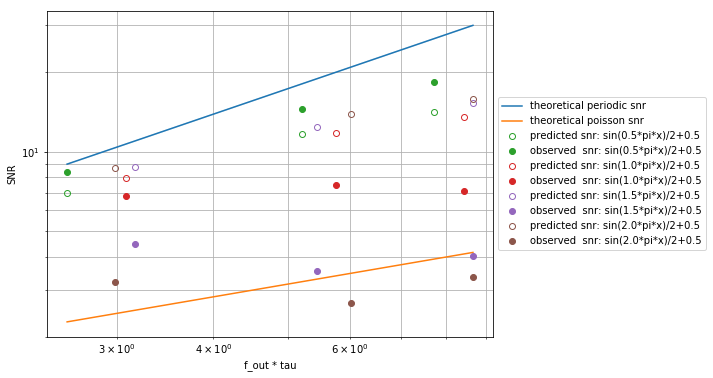

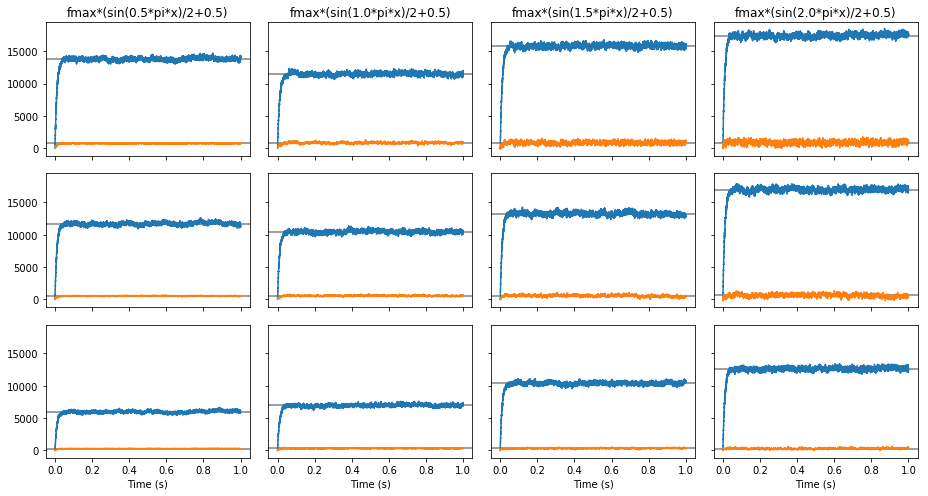

In [13]:
def plot_decode_stats(exp_data, tau):
    # plot filtered decodes and spikes out
    # plot on gamma plot
    fout = np.array(exp_data.fout)
    fend = np.array([fout.min(), fout.max()])
    fout = np.logspace(np.log10(fend[0]), np.log10(fend[1]))
    
    nrows = len(exp_data.fmax_outs)
    ncols = len(exp_data.fcn_fs)
    fig_snr, ax_snr = plt.subplots(figsize=(8, 6))
    fig_filt, axs_filt = plt.subplots(
        nrows=nrows, ncols=ncols,
        sharex=True, sharey=True,
        figsize=(ncols*3+1, nrows*2+1))
    
    snr_per = utils.get_snr_periodic(fout*tau)
    snr_per_high_lt_appx = np.sqrt(12)*fend*tau
    snr_poi = np.sqrt(2*fend*tau)
    per_color = ax_snr.loglog(fout*tau, snr_per, label="theoretical periodic snr")[0].get_color()
    ax_snr.loglog(fend*tau, snr_per_high_lt_appx, color=per_color, alpha=0.2)
    ax_snr.loglog(fend*tau, snr_poi, label="theoretical poisson snr")
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][2:]
    len_c = len(colors)
    for idx0, fmax_out in enumerate(exp_data.fmax_outs):
        for idx1, fcn_f in enumerate(exp_data.fcn_fs):
            bin_times = exp_data.bin_times[idx0][idx1]
            filtered_spikes = exp_data.filtered_spikes[idx0][idx1]
            filtered_decode = exp_data.filtered_decode[idx0][idx1]
            fin = exp_data.fin[idx0][idx1]
            fout = exp_data.fout[idx0][idx1]
            mean = exp_data.mean[idx0][idx1]
            snr = exp_data.snr[idx0][idx1]
            ax = axs_filt[idx0][idx1]
            ax.axhline(fin, color="k", alpha=0.5)
            ax.axhline(fout, color="k", alpha=0.5)
            ax.plot(bin_times, filtered_spikes)
            ax.plot(bin_times, filtered_decode)
            
            k_eff = fin/fout
            snr_th = utils.get_snr_gamma(fout*tau, k_eff)
            if idx0 == 0:
                label_o = "observed  snr: sin({:.1f}*pi*x)/2+0.5".format(fcn_f)
                label_t = "predicted snr: sin({:.1f}*pi*x)/2+0.5".format(fcn_f)
            else:
                label_o = None
                label_t = None
            ax_snr.loglog(fout*tau, snr_th, 'o', color=colors[idx1%len_c], fillstyle='none', label=label_t)
            ax_snr.loglog(fout*tau, snr, 'o', color=colors[idx1%len_c], label=label_o)
    lgd = ax_snr.legend(bbox_to_anchor=(1, 0.5), loc="center left")
    ax_snr.set_xlabel("f_out * tau")
    ax_snr.set_ylabel("SNR")
    ax_snr.grid(which="both")
    for idx1, fcn_f in enumerate(exp_data.fcn_fs):
        axs_filt[0][idx1].set_title("fmax*(sin({:.1f}*pi*x)/2+0.5)".format(fcn_f))
        axs_filt[-1][idx1].set_xlabel("Time (s)")
    plt.tight_layout()
    fig_snr.savefig("test_accumulator_snr.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
    fig_filt.savefig("test_accumulator_filt.png")
plot_decode_stats(EXP_DATA, TAU_READOUT)